In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint

from utils import get_dfs, concat_output_filename, load_head_items
from prep_organized_boycotts import (
    group_by_age, group_by_gender, group_by_genre,
    group_by_occupation, group_by_power, group_by_state, group_by_genre_strict
)

In [ ]:
dfs = get_dfs('ml-1m')

In [ ]:
users_df = dfs['users']
ratings_df = dfs['ratings']
print(users_df.head())
print(ratings_df.head())

In [ ]:
from collections import defaultdict
from scipy.spatial.distance import cosine

groups = group_by_gender(users_df) + group_by_genre(users_df, ratings_df, dfs['movies'], 'ml-1m') + group_by_age(users_df)
#groups = group_by_gender(users_df)
groups += [{'name': 'all', 'df': users_df}]
movie_set = sorted(list(set(ratings_df.movie_id)))

user_to_vec = {}
group_to_implicit_vecs = defaultdict(list)
group_to_explicit_vecs = defaultdict(list)

# we're gonna do a bunch of stuff at once
for group in groups:
    print(group['name'])
    
    # Get all the user ids in this boycott group (e.g. all Comedy fans or all users of a certain age range)
    group_uid_set = set(list(group['df'].user_id))
    
    for user_id in group_uid_set:
        # get all the ratings for this user
        user_ratings = ratings_df[ratings_df.user_id == user_id]
        user_movie_set = list(set(user_ratings.movie_id))
        
        implicit_vec = []
        explicit_vec = []
        for movie_id in movie_set:
            if movie_id in user_movie_set:
                implicit_vec.append(1)
                rating = user_ratings[user_ratings.movie_id == movie_id].rating
                explicit_vec.append(int(rating))
            else:
                implicit_vec.append(0)
                explicit_vec.append(3)
        implicit_vec = np.array(implicit_vec)
        explicit_vec = np.array(explicit_vec)

        group_to_implicit_vecs[group['name']].append(implicit_vec)
        group_to_explicit_vecs[group['name']].append(explicit_vec)

group_to_type_to_centroid = defaultdict(dict)
for group_to_vecs, type_ in [
    (group_to_implicit_vecs, 'implicit',),
    (group_to_explicit_vecs, 'explicit',),
]:
    for group, vecs in group_to_vecs.items():
        group_to_type_to_centroid[group][type_] = np.mean(vecs, axis=0)

group_to_group_to_vectype_to_distancetype_to_ = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
"""
{
    comedy:
        western:
            explicit:
                cosine
                    0.5
                euclidean
                    0.4
            implicit
                cosine
                    0.3
                euclidean
                    0.2
        drama
        ...
        ...
    western:
        ...
        ...
}
"""
for group, type_to_centroid in group_to_type_to_centroid.items():
    for type_, centroid in type_to_centroid.items():
        for group2, type_to_centroid2 in group_to_type_to_centroid.items():
            if group == group2:
                continue
            for type_2, centroid2 in type_to_centroid2.items():
                if type_2 != type_:
                    continue
#                 print('centroid below')
#                 print(centroid)
#                 print('centroid2 below')
#                 print(centroid2)
                group_to_group_to_vectype_to_distancetype_to_[
                    group][group2][type_]['euclidean'] = np.linalg.norm(centroid - centroid2)
                group_to_group_to_vectype_to_distancetype_to_[
                    group][group2][type_]['cosine'] = cosine(centroid, centroid2)
        
def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {key: default_to_regular(val) for key, val in d.items()}
    return d

group_to_group_to_vectype_to_distancetype_to_ = default_to_regular(group_to_group_to_vectype_to_distancetype_to_)          
pprint(group_to_group_to_vectype_to_distancetype_to_)
import json
with open('some_distances.json', 'w') as f:
    json.dump(group_to_group_to_vectype_to_distancetype_to_, f)

In [32]:
import pandas as pd
import json
print('*')
with open('some_distances.json', 'r') as f:
    group_to_group_to_vectype_to_distancetype_to_ = json.load(f)
    


row_dicts = []
for group, group_to_vectype_to_distancetype_to_ in group_to_group_to_vectype_to_distancetype_to_.items():
    print(group)
    if group == 'all':
        continue
    row_dict = {}
    row_dict['name'] = group
    for group2, vectype_to_distancetype_to_ in group_to_vectype_to_distancetype_to_.items():
        if group2 != 'all':
            continue
        for vectype, distancetype_to_ in vectype_to_distancetype_to_.items():
            for distancetype, val in distancetype_to_.items():
                row_dict['{}_{}'.format(vectype, distancetype)] = val
    row_dicts.append(row_dict)

df = pd.DataFrame(row_dicts)
df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(df.name)
]

print(df)

*
male users excluded
female users excluded
Fans of Drama excluded using threshold 4
Fans of Animation excluded using threshold 4
Fans of Children's excluded using threshold 4
Fans of Musical excluded using threshold 4
Fans of Comedy excluded using threshold 4
Fans of Sci-Fi excluded using threshold 4
Fans of War excluded using threshold 4
Fans of Thriller excluded using threshold 4
Fans of Action excluded using threshold 4
Fans of Adventure excluded using threshold 4
Fans of Crime excluded using threshold 4
Fans of Romance excluded using threshold 4
Fans of Film-Noir excluded using threshold 4
Fans of Fantasy excluded using threshold 4
Fans of Mystery excluded using threshold 4
Fans of Horror excluded using threshold 4
Fans of Documentary excluded using threshold 4
Fans of Western excluded using threshold 4
Under 18 excluded
18-24 excluded
25-34 excluded
35-44 excluded
45-49 excluded
50-55 excluded
56+ excluded
all
    explicit_cosine  explicit_euclidean  implicit_cosine  implicit_euc

In [33]:
with open('all_ratios.json', 'r') as f:
    all_ratios = json.load(f)
lb_ratios = all_ratios['lb']
nb_ratios = all_ratios['nb']

row_dicts = []
for key, val in lb_ratios.items():
    row_dict = {
        'name': key,
        'like-boycott-ratio': val,
        'non-boycott-ratio': nb_ratios[key]
    }
    row_dicts.append(row_dict)
ratios_df = pd.DataFrame(row_dicts)

df = df.merge(right=ratios_df, on='name', how='inner')
print(df)

    explicit_cosine  explicit_euclidean  implicit_cosine  implicit_euclidean  \
0          0.000005            0.595161         0.003839            0.526198   
1          0.000033            1.508274         0.036824            1.333507   
2          0.000019            1.377473         0.015235            0.875597   
3          0.000411            6.227340         0.025233            4.471157   
4          0.000283            5.171874         0.026330            2.994761   
5          0.000439            6.550788         0.037752            4.329452   
6          0.000029            1.653046         0.027798            1.172364   
7          0.000119            3.172021         0.026797            1.229178   
8          0.000253            4.848333         0.011929            3.188820   
9          0.000059            2.365892         0.021235            1.022610   
10         0.000056            2.133451         0.027856            1.122937   
11         0.000143            3.464690 

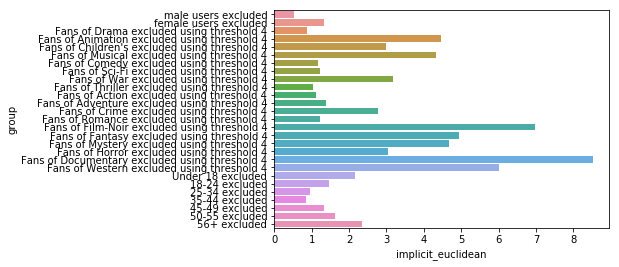

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(y='group', x='implicit_euclidean', data=df)
plt.show()

In [ ]:
total = len(users_df.index)
print('total users', total)
for group in group_by_genre(users_df, ratings_df, dfs['movies'], 'ml-1m'):
    df = group['df']
    users = sorted(list(set(df.user_id)))
    print(group['name'], len(users))
    print(users)

In [36]:
from scipy.stats import pearsonr

print(pearsonr(df['like-boycott-ratio'], df['non-boycott-ratio']))

print('\n===')
for distance in [
    'explicit_cosine', 'explicit_euclidean',
    'implicit_cosine', 'implicit_euclidean',
]:
    for ratio in [
        'like-boycott-ratio', 'non-boycott-ratio'
    ]:
        x = pearsonr(df[distance], df[ratio])
        print(distance, ratio)
        print(x)

(-0.2517790493813986, 0.2051895520467565)

===
explicit_cosine like-boycott-ratio
(0.17343286183996046, 0.3869707571918657)
explicit_cosine non-boycott-ratio
(0.5229565755937297, 0.005128727379733721)
explicit_euclidean like-boycott-ratio
(0.12765561025499855, 0.5257316906423292)
explicit_euclidean non-boycott-ratio
(0.4728535160758278, 0.012744075359620336)
implicit_cosine like-boycott-ratio
(0.6756607708191479, 0.00010995524837304854)
implicit_cosine non-boycott-ratio
(-0.1798469235031174, 0.36937614621154957)
implicit_euclidean like-boycott-ratio
(0.22022364166392094, 0.26968501205685014)
implicit_euclidean non-boycott-ratio
(0.49769426347533435, 0.008251787352448794)


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


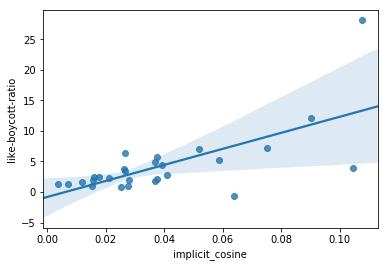

In [29]:
sns.regplot(x='implicit_cosine', y='like-boycott-ratio', data=df)
plt.show()